In [1]:
# all the necessary imports
import re
import pandas as pd
import nltk
# nltk.download('punkt') ----> udkommenter denne linje, hvis du ikke har nltk installeret
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# nltk.download('stopwords') ----> udkommenter denne linje, hvis du ikke har nltk installeret
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix




In [2]:
data = pd.read_csv('995,000_rows.csv',dtype = str)

In [3]:

def cleanText(text):
    # lower case
    if not isinstance(text, str):
        text = str(text)
    
    if isinstance(text, str):
        text = text.lower()

    # should not contain multiple spaces, tabs or newlines
    text = re.sub(r'\s+', ' ', text)

    #  january 18, 2018. jan 18, 2018. 2018-01-18
    date_pattern = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+\d{1,2}(?:,\s+|\s+)\d{4}\b|\b\d{4}-\d{2}-\d{2}\b'

    text = re.sub(date_pattern, '<DATE>', text)
    # nov. 5
    date_pattern2 = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\.\s+\d{1,2}\b'
    text = re.sub(date_pattern2, '<DATE>', text)

    # replace numbers with <NUM>
    text = re.sub(r'\d+', '<NUM>', text)

    # replace urls with <URL>
    text = re.sub(r'(http|https)://[^\s]*', '<URL>', text)

    # replace emails with <EMAIL>
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b', '<EMAIL>', text)


    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

domain                             type                      
100percentfedup.com                bias                            10
2016-11-13T15:38:41.407+02:00      2018-02-10 13:43:39.521661       1
21stcenturywire.com                conspiracy                    2352
4threvolutionarywar.wordpress.com  bias                           631
70news.wordpress.com               fake                           261
                                                                 ... 
yournationnews.com                 clickbait                        4
yournewswire.com                   clickbait                     1230
zeenews.india.com                  reliable                       299
zerohedge.com                      conspiracy                    4185
zootfeed.com                       conspiracy                      22
Length: 619, dtype: int64
type
reliable                      218564
political                     194518
bias                          133232
fake                      

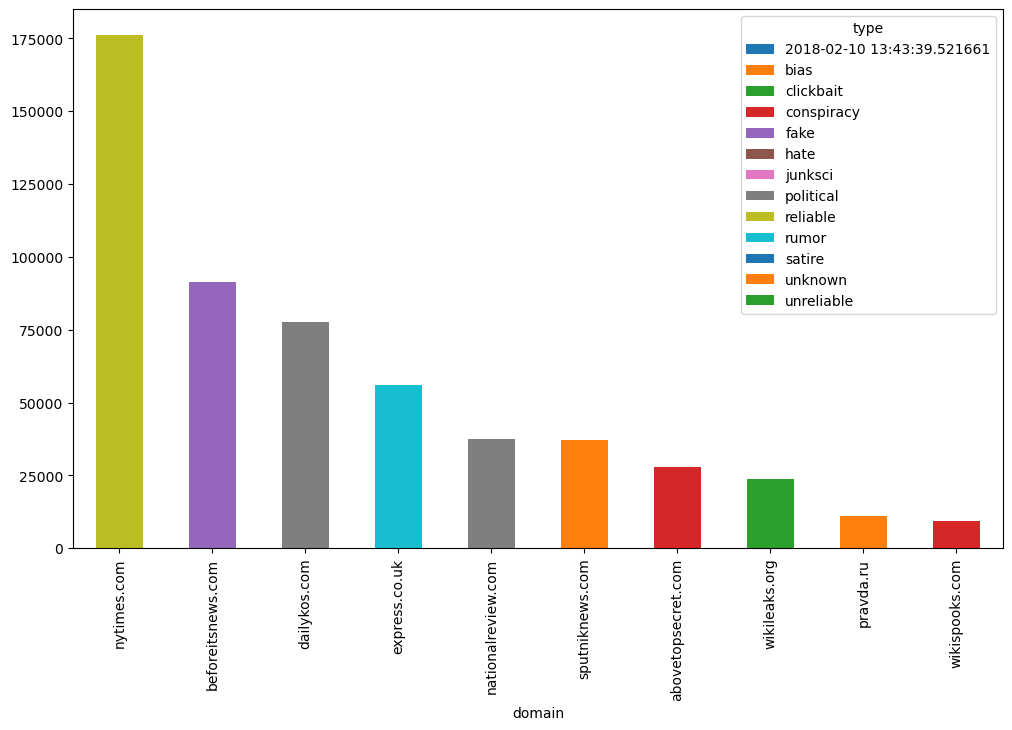

Reliable percent: 21.966231155778896


In [4]:
# initial exploratory data analysis

# see how many domains are in the dataset
domains = data['domain'].value_counts()
# print(domains)

# see if there are any missing values in ['domain']
missing_domain = data['domain'].isnull().sum()
# print('Missing domain:', missing_domain)

# see if how many domains have 'reliable' as their type
reliable_domains = data[data['type'] == 'reliable']['domain'].value_counts()
# print(reliable_domains)

# see for each domain how many reliable and fake news articles they have
reliable_fake = data.groupby(['domain', 'type']).size()
print(reliable_fake)


# see how many diferent types there are and print them
types = data['type'].value_counts()
print(types)


# plot 10 domains with the most articles with their type

reliable_fake = reliable_fake.unstack()
# fillna(0) replaces all NaN values with 0
reliable_fake = reliable_fake.fillna(0)
reliable_fake['total'] = reliable_fake['reliable'] + reliable_fake['fake'] + reliable_fake['satire'] + reliable_fake['bias'] + reliable_fake['conspiracy'] + reliable_fake['hate']+ reliable_fake['junksci'] + reliable_fake['clickbait'] + reliable_fake['unreliable'] + reliable_fake['political'] + reliable_fake['rumor'] + reliable_fake['unknown'] 
reliable_fake = reliable_fake.sort_values(by='total', ascending=False)
reliable_fake = reliable_fake.head(10)
reliable_fake = reliable_fake.drop(columns='total')
reliable_fake.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.show()


# print what percent of the articles are of type reliable
reliable_percent = types['reliable'] / data.shape[0] * 100
print('Reliable percent:', reliable_percent)


In [5]:
# removing missing values, classifying the data,

data = data.dropna(subset=['type', 'content'])

# replace 'political' and 'clickbait' with 'reliable'
data['type'] = data['type'].replace(['political', 'clickbait'], 'reliable')

# replace 'bias' and 'satite' with 'fake'
data['type'] = data['type'].replace(['bias', 'satire'], 'fake')

#  remove all the other types of news except 'reliable' and 'fake'
data = data[data['type'].isin(['reliable', 'fake'])]


print('Total rows after removing missing values:', data.shape[0])

reliable_percent = data['type'].value_counts()['reliable'] / data.shape[0] * 100
print('Reliable percent:', reliable_percent)


Total rows after removing missing values: 691768
Reliable percent: 63.6764059626927


In [6]:
# cleaning the text
data['content'] = data['content'].apply(cleanText)

In [7]:
# tokenization
data['tokens'] = data['content'].apply(nltk.word_tokenize)

In [8]:
# removing stopwords and stemming the tokens

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer() 

def process_tokens(tokens):
    # remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # stemming
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return stemmed_tokens

data['processed_tokens'] = data['tokens'].apply(process_tokens).apply(lambda x: ' '.join(x))
# data['processed_tokens'] = data['content'].apply(lambda x:' '.join([stemmer.stem(word) for word in nltk.word_tokenize(x)]))

In [3]:
# reading the other cleaned data
# cleaned_stemmed = pd.read_csv('995,000_cleaned_stemmed2.csv', dtype=str)

# cleaned_stemmed = cleaned_stemmed.dropna(subset=['type', 'content'])

# # replace 'political' and 'clickbait' with 'reliable'
# cleaned_stemmed['type'] = cleaned_stemmed['type'].replace(['political', 'clickbait'], 'reliable')

# # replace 'bias' and 'satite' with 'fake'
# cleaned_stemmed['type'] = cleaned_stemmed['type'].replace(['bias', 'satire'], 'fake')
# #  remove all the other types of news except 'reliable' and 'fake'
# cleaned_stemmed = cleaned_stemmed[cleaned_stemmed['type'].isin(['reliable', 'fake'])]

# print('Total rows after removing missing values:', cleaned_stemmed.shape[0]) 

# print(cleaned_stemmed['type'].value_counts())

# # percent reliable
# reliable_percent = cleaned_stemmed['type'].value_counts()['reliable'] / cleaned_stemmed.shape[0] * 100
# print('Reliable percent:', reliable_percent)

Total rows after removing missing values: 691768
type
reliable    440493
fake        251275
Name: count, dtype: int64
Reliable percent: 63.6764059626927


In [9]:
# using  TfidfVectorizer to convert the text data into numerical data
tfidvec = TfidfVectorizer(stop_words='english',max_df=0.7)

In [10]:
# split the data into training and testing sets

# X = CountVectorizer.fit_transform(cleaned_stemmed['content'])
# X = tfidvec.fit_transform(cleaned_stemmed['content'])
X = tfidvec.fit_transform(data['processed_tokens'])


X_train, X_test_1, y_train, y_test_1  = train_test_split(X, data['type'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_1, y_test_1, test_size=0.5, random_state=42)

In [11]:
# read the liad tsv file
liar_data_test = pd.read_csv('LIARDATASET/train.tsv', sep='\t', header=None)

# only keep the 'true' and 'false' labels
liar_data_test = liar_data_test[liar_data_test[1].isin(['true', 'false'])]

X_liar = liar_data_test[2]
y_liar = liar_data_test[1]

# change the labels to 'reliable' and 'fake'
y_liar = y_liar.replace('true', 'reliable')
y_liar = y_liar.replace('false', 'fake')

# clean the text
X_liar = X_liar.apply(cleanText)

# tokenize the text
X_liar = X_liar.apply(nltk.word_tokenize)

# remove stopwords and stem the tokens
# X_liar = X_liar.apply(process_tokens).apply(lambda x: ' '.join(x))

# data['processed_tokens'] = data['content'].apply(lambda x:' '.join([stemmer.stem(word) for word in nltk.word_tokenize(x)]))
# X_liar = X_liar.apply(lambda x:' '.join([stemmer.stem(word) for word in nltk.word_tokenize(x)]))
X_liar = X_liar.apply(process_tokens).apply(lambda x: ' '.join(x))




In [12]:
# scaling the data

scale = StandardScaler(with_mean=False)

X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [13]:
# training baseline model: logistic regression

logistic_model = LogisticRegression(max_iter=3500, random_state=42, n_jobs=-1)

logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=3500, n_jobs=-1, random_state=42)

PREDICTIONS WITH LOGISTIC REGRESSION:
accuracy:  0.7928502247856947
f score:  0.793714773908709
liar accuracy:  0.4906020157995097
liar f score:  0.4828504100144285


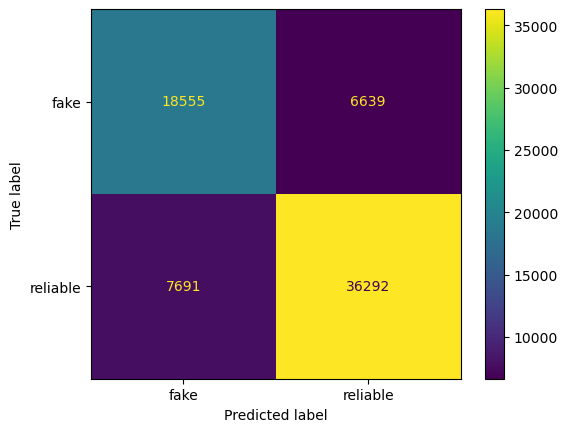

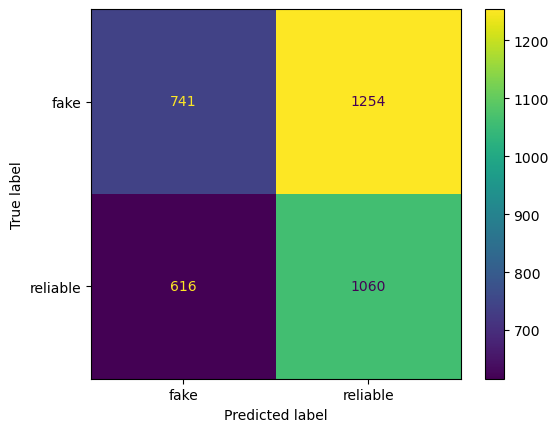

In [14]:
# predicting: testing set
print ("PREDICTIONS WITH LOGISTIC REGRESSION:")
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)
# also get the f score.
f_score = f1_score(y_test, y_pred, average='weighted')
print("f score: ", f_score)

# predicting: liar dataset
liar_predic = logistic_model.predict(scale.transform(tfidvec.transform(X_liar)))
accuracy = accuracy_score(y_liar, liar_predic)
print("liar accuracy: ", accuracy)
# also get the f score.
f_score = f1_score(y_liar, liar_predic, average='weighted')
print("liar f score: ", f_score)

# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=logistic_model.classes_)
conf_matrix.plot()
plt.show()


# confusion matrix for liar dataset

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_liar, liar_predic), display_labels=logistic_model.classes_)
conf_matrix.plot()
plt.show()

In [15]:
# training svm model:
svc = svm.LinearSVC(max_iter=3500, random_state=42) # around 3500 max uters for better results

svc.fit(X_train, y_train)


c:\Users\atta_\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\atta_\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=3500, random_state=42)

PREDICTIONS WITH SVM
accuracy:  0.7811122193792734
f score:  0.7822683550390022
liar accuracy:  0.4930536638518115
liar f score:  0.486021074596716


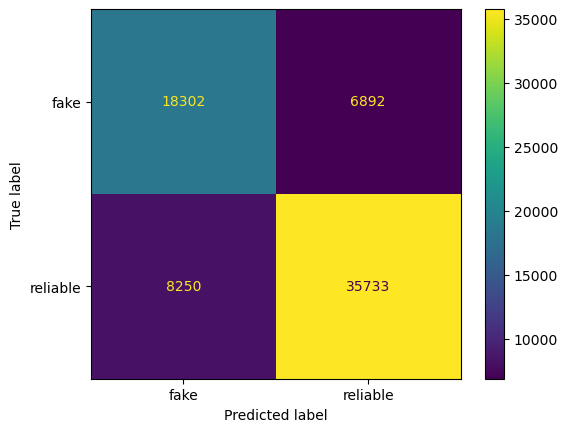

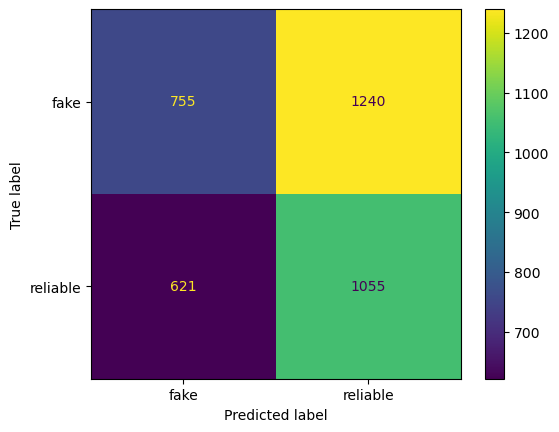

In [16]:
# predicting with the svm model
print("PREDICTIONS WITH SVM")
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)
# also get the f score.
f_score = f1_score(y_test, y_pred, average='weighted')
print("f score: ", f_score)

# predicting: liar dataset
liar_predic = svc.predict(scale.transform(tfidvec.transform(X_liar)))
accuracy = accuracy_score(y_liar, liar_predic)
print("liar accuracy: ", accuracy)
# also get the f score.
f_score = f1_score(y_liar, liar_predic, average='weighted')
print("liar f score: ", f_score)

# confusion matrix
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=svc.classes_)
conf_matrix.plot()
plt.show()

# confusion matrix for liar dataset

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_liar, liar_predic), display_labels=svc.classes_)
conf_matrix.plot()
plt.show()

In [17]:
# training random forest model

clf = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs = -1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

PREDICTING WITH RANDOM FOREST MODEL
accuracy:  0.8524509591338162
f score:  0.8431564067763738
liar accuracy:  0.481067828929447
liar f score:  0.39422558080102693


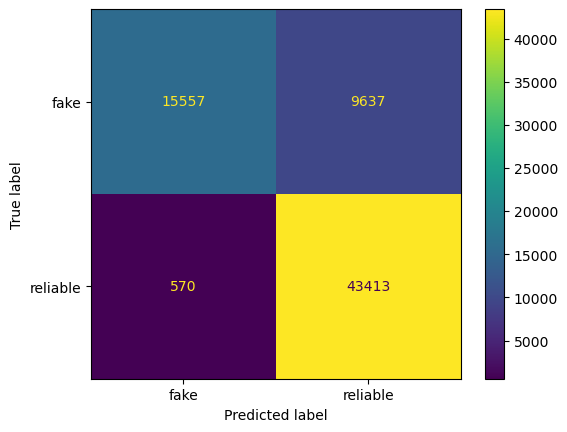

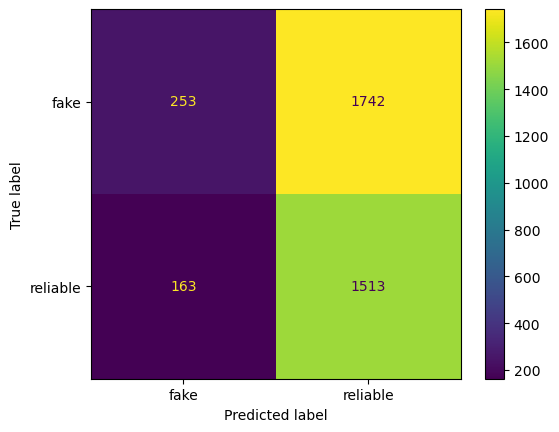

In [18]:
# predicitng with the random forest model
print("PREDICTING WITH RANDOM FOREST MODEL")
y_pred = clf.predict(X_test)
print("accuracy: ", accuracy_score(y_test, y_pred))
# also get the f score.
f_score = f1_score(y_test, y_pred, average='weighted')
print("f score: ", f_score)

# predicting: liar dataset
liar_predic = clf.predict(scale.transform(tfidvec.transform(X_liar)))
accuracy = accuracy_score(y_liar, liar_predic)
print("liar accuracy: ", accuracy)
# also get the f score.
f_score = f1_score(y_liar, liar_predic, average='weighted')
print("liar f score: ", f_score)

# confusion matrix
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=clf.classes_)
conf_matrix.plot()
plt.show()

# confusion matrix for liar dataset

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_liar, liar_predic), display_labels=clf.classes_)
conf_matrix.plot()
plt.show()

In [19]:
# training naive bayes model

naive = MultinomialNB() # try with countvectorizer also since it is a naive bayes model and it is better with countvectorizer, appearently.
naive.fit(X_train, y_train)

MultinomialNB()

PREIDCTING WITH NAIVE BAYES
accuracy:  0.5751622649146393
f score:  0.5475899375678593
liar accuracy:  0.4614546445110324
liar f score:  0.31128204454876945


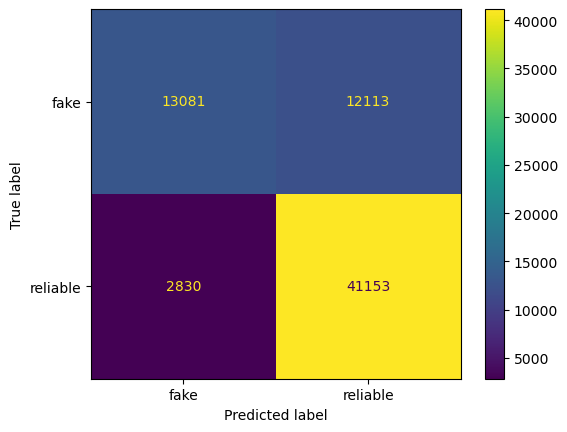

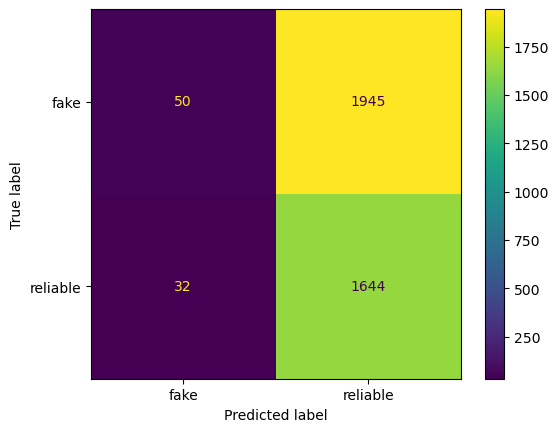

In [20]:
# predicting with the naive bayes model
print("PREIDCTING WITH NAIVE BAYES")
y_pred = naive.predict(X_test)

accuracy = accuracy_score(y_val, y_pred)
print("accuracy: ", accuracy)
# also get the f score.
f_score = f1_score(y_val, y_pred, average='weighted')
print("f score: ", f_score)

# predicting: liar dataset
liar_predic = naive.predict(scale.transform(tfidvec.transform(X_liar)))
accuracy = accuracy_score(y_liar, liar_predic)
print("liar accuracy: ", accuracy)
# also get the f score.
f_score = f1_score(y_liar, liar_predic, average='weighted')
print("liar f score: ", f_score)

# confusion matrix
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=naive.classes_)
conf_matrix.plot()
plt.show()

# confusion matrix for liar dataset

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_liar, liar_predic), display_labels=naive.classes_)
conf_matrix.plot()
plt.show()


In [ ]:
# training neural network model

mlp = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(128,64))

mlp.fit(X_train, y_train)

In [ ]:
# predicting with the neural network model
print("PREDICTING WITH NEURAL NETWORK MODEL:")
y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

# predicting: liar dataset
liar_predic = mlp.predict(scale.transform(tfidvec.transform(X_liar)))
accuracy = accuracy_score(y_liar, liar_predic)
print("liar accuracy: ", accuracy)